In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BSBSSSSB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    152.7| 32.6089| -85.0756|       SNWD|USC00096148|    34|[00 00 00 00 00 0...|1998.0|BSBSSSSB|
|    152.7| 32.6089| -85.0756|       SNWD|USC00096148|     0|[00 00 00 00 00 0...|1999.0|BSBSSSSB|
|    152.7| 32.6089| -85.0756|       SNWD|USC00096148|     0|[00 00 00 00 00 0...|2000.0|BSBSSSSB|
|    152.7| 32.6089| -85.0756|       SNWD|USC00096148|    19|[00 7E C0 54 F0 5...|2002.0|BSBSSSSB|
|    152.7| 32.6089| -85.0756|       SNWD|USC00096148|    35|[00 7E 00 7E 00 7...|2003.0|BSBSSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

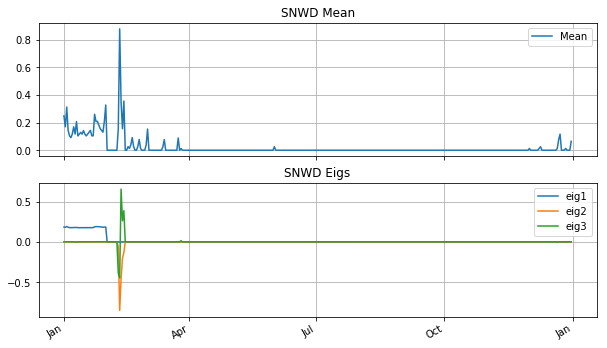

In [117]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [118]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]
print shape(EigVec)

(365, 3)


### plot the percent of residual variance on average

## Process whole dataframe to find best and worse residuals

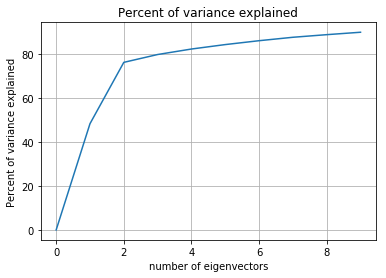

In [119]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [120]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [121]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1.0)
#df3 = df2
print 'after filter',df3.count()

before filter 2015
after filter 103


In [122]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [123]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

+------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|           coeff_1|               res_1|           coeff_2|               res_2|             coeff_3|               res_3|
+------------------+--------------------+------------------+--------------------+--------------------+--------------------+
| 989.8345245907133|6.897724450731896E-4|-2.825224341758239|6.816313839399182E-4|-0.01858796337210794|6.816310315376029E-4|
| 103.0751984881246|  0.7571558950376467| 0.671081099131387|   0.757145601391848|  0.2420536836789542|  0.7571442622006122|
| 45.98461688663233|  0.9218155087957245|0.8841400008656755|  0.9217866061534002| 0.16203322131791292|  0.9217856354118894|
|41.699198454802946|  0.8186978840154917| 0.868258675375407|  0.8186192798210195| 0.13280042169922796|  0.8186174409707531|
| 36.88280420965145|  0.9272904811360495|0.9302361398007791|  0.9272862359830134| 0.15919722197122033|  0.9272845486974798|
|31.2995

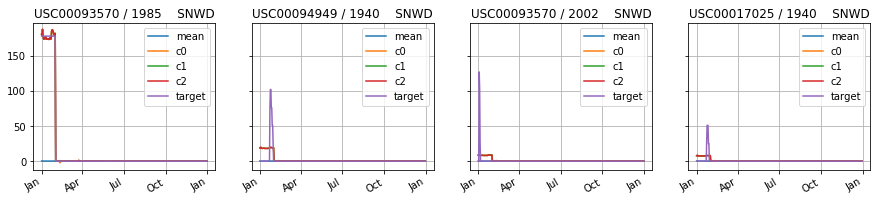

In [124]:
df4=df3.filter(df3.res_1<1.0).sort(df3.coeff_1,ascending = False)
rows =df4.take(4)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show()
row_n = 1
column_n = 4
fig,axes=plt.subplots(1,4, sharex='col', sharey='row',figsize=(15,3));
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False)

+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+
|            coeff_1|             res_1|            coeff_2|               res_2|            coeff_3|               res_3|
+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+
|-2.5917706479002818|0.9999664478768214| -443.6147287588262| 0.01699978890741488|  52.92625870678841|0.003008128238046...|
|-2.5282539397155652| 0.999968261275071| -429.8047493899035| 0.08271236855133847| 119.02584979557571|0.012367783560811824|
|-1.9255116046910863|0.9999501935507851| -271.3511897502637|0.010812480278995638| 10.066418747826486|0.009451213376342462|
|-1.8932635062039704|0.9999612000565257| -259.0015159146668| 0.07506714963739534|-136.64560679496668|0.005321396426189087|
|-1.7866472351296436|0.9999633203284237|-224.43107300315384| 0.26461068339051325|-173.27854105012625| 0.06062983557903302|
|-1.179618549847

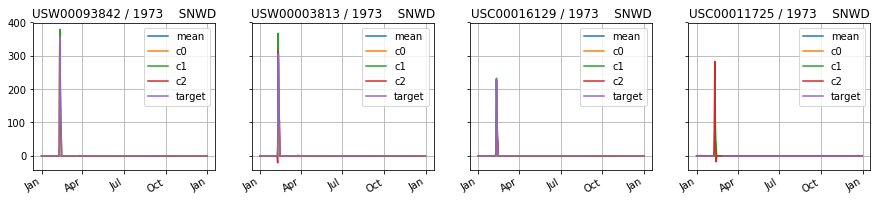

In [125]:
df4=df3.filter(df3.res_1<1.0).sort(df3.coeff_1)
rows =df4.take(12)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show(12)
row_n = 1
column_n = 4
fig,axes=plt.subplots(1,4, sharex='col', sharey='row',figsize=(15,3));
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False)

+-------------------+------------------+------------------+------------------+--------------------+------------------+
|            coeff_1|             res_1|           coeff_2|             res_2|             coeff_3|             res_3|
+-------------------+------------------+------------------+------------------+--------------------+------------------+
|-0.9178559226995578|0.9999564035593553|1.0581092297294987|0.9998984649595487| 0.07777040153556433| 0.999898151927185|
|-0.9164705795939789|0.9999190425568986|1.0551912392755647|0.9998117222066881|  0.0744669615220336|0.9998111877075676|
|-0.9095045827359363|0.9998562587841985|1.0414002063056675|0.9996678041379218| 0.06761558901306199|0.9996670096904233|
|-0.9045951465296964|0.9998579374137875|1.0316155893213783|0.9996731720631928| 0.06230031544623922| 0.999672497855266|
|-0.9029056200630985|0.9997462149807685|1.0283355427708174|0.9994170216990754| 0.06124477304953309| 0.999415854031208|
|-0.9028065088339722|0.9996849930932309|1.028139

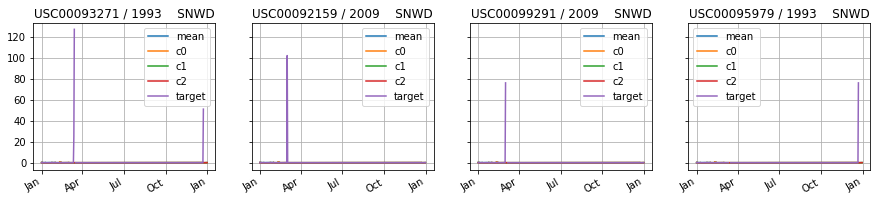

In [143]:
df4=df3.filter(df3.res_2<1).sort(df3.coeff_2,ascending = False)
rows =df4.take(4)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show()
row_n = 1
column_n = 4
fig,axes=plt.subplots(1,4, sharex='col', sharey='row',figsize=(15,3));
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False)

+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+
|            coeff_1|             res_1|            coeff_2|               res_2|            coeff_3|               res_3|
+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+
|-2.5917706479002818|0.9999664478768214| -443.6147287588262| 0.01699978890741488|  52.92625870678841|0.003008128238046...|
|-2.5282539397155652| 0.999968261275071| -429.8047493899035| 0.08271236855133847| 119.02584979557571|0.012367783560811824|
|-1.9255116046910863|0.9999501935507851| -271.3511897502637|0.010812480278995638| 10.066418747826486|0.009451213376342462|
|-1.8932635062039704|0.9999612000565257| -259.0015159146668| 0.07506714963739534|-136.64560679496668|0.005321396426189087|
|-1.7866472351296436|0.9999633203284237|-224.43107300315384| 0.26461068339051325|-173.27854105012625| 0.06062983557903302|
|-1.179618549847

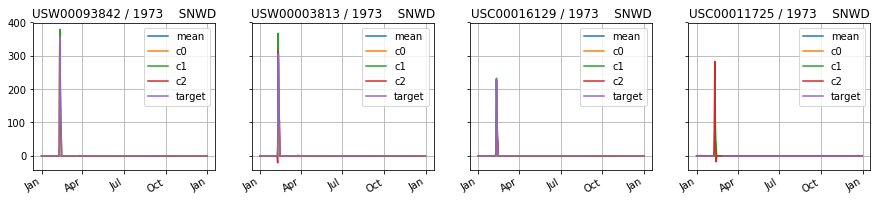

In [144]:
df4=df3.filter(df3.res_2<1).sort(df3.coeff_2)
rows =df4.take(4)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show(12)
row_n = 1
column_n = 4
fig,axes=plt.subplots(1,4, sharex='col', sharey='row',figsize=(15,3));
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False)

+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+
|            coeff_1|             res_1|            coeff_2|               res_2|            coeff_3|               res_3|
+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+
|-2.5282539397155652| 0.999968261275071| -429.8047493899035| 0.08271236855133847| 119.02584979557571|0.012367783560811824|
|-2.5917706479002818|0.9999664478768214| -443.6147287588262| 0.01699978890741488|  52.92625870678841|0.003008128238046...|
|-0.9838737428893503|0.9999116599409423| -12.58179463301837|   0.985465110491137|  39.71515333954735|  0.8415218182213003|
|-0.9832771833509228|0.9999064355126394|-12.568211253997195|  0.9846200476772078| 39.380290447989076|  0.8345424276081658|
|-0.9592820522018946|0.9998392311358606| -9.109370278877957|  0.9853420107333658|  29.35430759853751|  0.8348019965194574|
|-0.959282052201

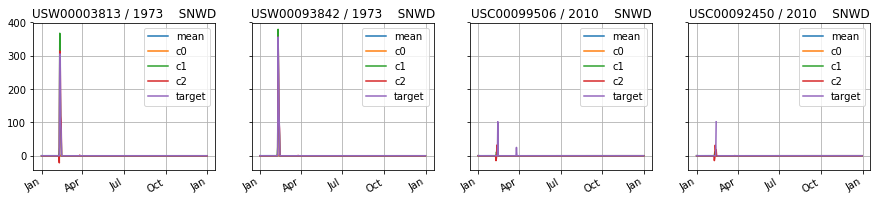

In [128]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_3,ascending = False)
rows =df4.take(4)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show()
row_n = 1
column_n = 4
fig,axes=plt.subplots(1,4, sharex='col', sharey='row',figsize=(15,3));
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False)

+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+
|            coeff_1|             res_1|            coeff_2|              res_2|             coeff_3|               res_3|
+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+
|-1.7866472351296436|0.9999633203284237|-224.43107300315384|0.26461068339051325| -173.27854105012625| 0.06062983557903302|
|-1.8932635062039704|0.9999612000565257| -259.0015159146668|0.07506714963739534| -136.64560679496668|0.005321396426189087|
|-1.1393496550506226|0.9997700166102815| -63.78644612318356| 0.2789294283921146|  -34.01366672093526| 0.07395988936467711|
|-1.0570446494661958|0.9995554390441032| -42.47475728131859|0.28175046293830597| -22.809306450844474| 0.07475119318043434|
|-0.9102601058099378|0.9997396870695876|-1.9890877842612564| 0.9960493582195119|  -20.08286818264002|  0.7648074549826218|
|-0.909705483838

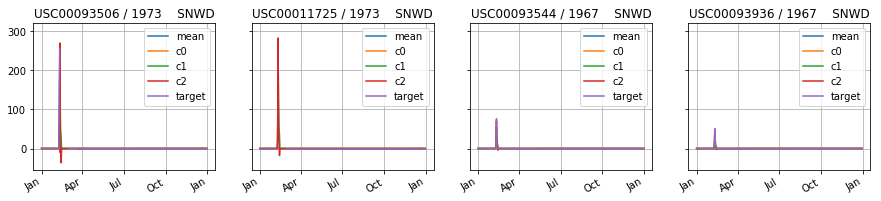

In [129]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_3)
rows =df4.take(12)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show(12)
row_n = 1
column_n = 4
fig,axes=plt.subplots(1,4, sharex='col', sharey='row',figsize=(15,3));
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False)

In [130]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.show(4)
df4.select('coeff_2','res_2').show(4)
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3','res_3').show(12)

+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|               res_2|               res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
|-2.5917706479002818|-443.6147287588262|  52.92625870678841|    119.5|BSBSSSSB| 32.5161| -84.9422|       SNWD|0.9999664478768214| 0.01699978890741488|0.003008128238046...|0.9956344851122549|USW00093842| 201082.0|     0|[00 00 00 00 00 0...|1973.0|
|-2.5282

IndexError: list index out of range

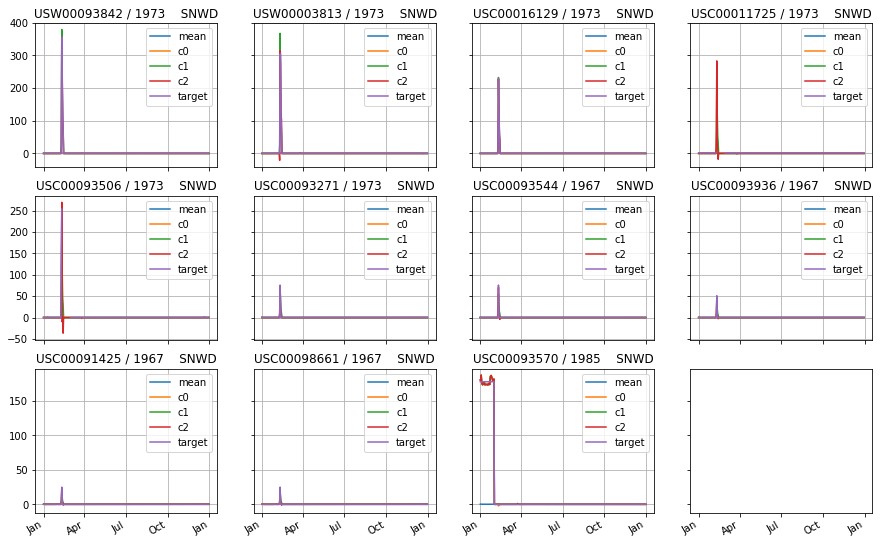

In [131]:
plot_recon_grid(rows)

In [132]:
df3.sort?

In [133]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+-------------------+--------------------+
|            coeff_2|               res_2|
+-------------------+--------------------+
| -2.825224341758239|6.816313839399182E-4|
|-20.310600885779007|  0.2909069455126284|
|-20.310600885779007|  0.2909069455126284|
| -42.47475728131859| 0.28175046293830597|
+-------------------+--------------------+
only showing top 4 rows



IndexError: list index out of range

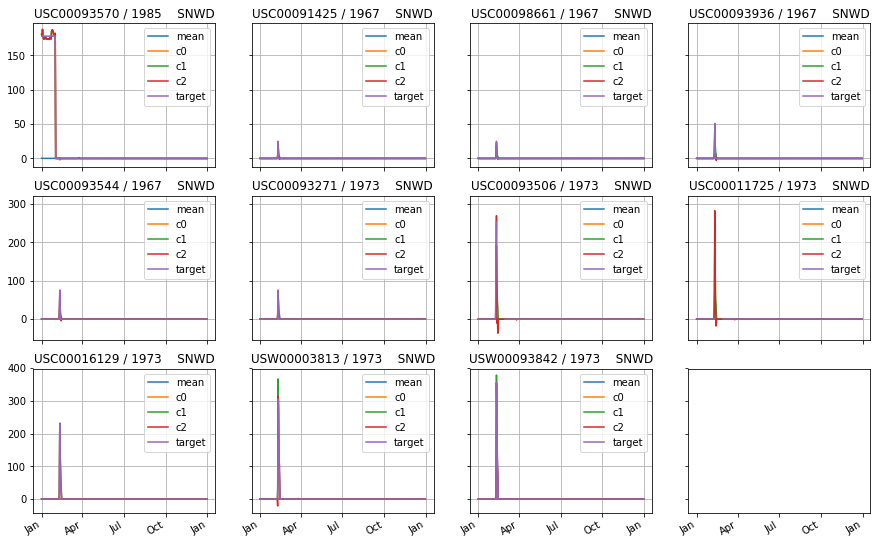

In [134]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.998212868762
residual normalized norm  after mean + top eigs: [ 0.00068977  0.00068163  0.00068163]


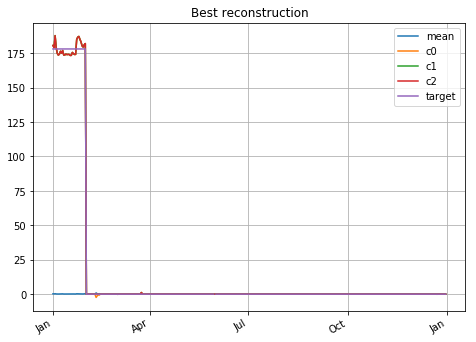

In [137]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [138]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

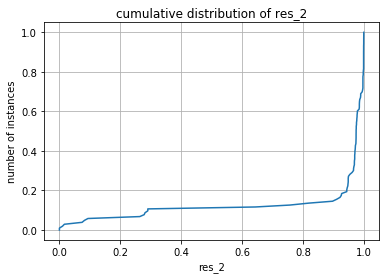

In [139]:
plot_CDF('res_2')

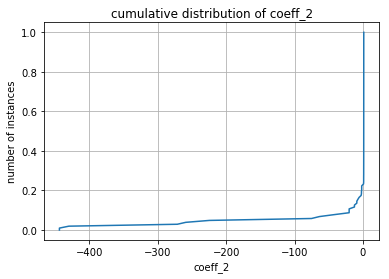

In [140]:
plot_CDF('coeff_2')

In [141]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [142]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.4M	../../Data/Weather/US_Weather_BSBSSSSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.5M	../../Data/Weather/decon_BSBSSSSB_PRCP.parquet
1.1M	../../Data/Weather/decon_BSBSSSSB_SNWD.parquet
